<b>Use Gemini to prompt Stable Diffusion</b>

Finding the right words to prompt an image generator can be a chore. Use Google's latest model release, Gemini, to prompt Stable Diffusion to produce amazing generated imagery.

This notebook includes modified code from [woctezuma/stable-diffusion-colab](https://github.com/woctezuma/stable-diffusion-colab). Thanks.

In [3]:
#@title Check for a GPU
#todo fail if this fails

import os

if os.system('nvidia-smi'):
  raise Exception("No GPU found. Access a GPU through Runtime > Change runtime type and try again.")

In [2]:
#@title Configure Gemini API key

#Access your Gemini API key

import google.generativeai as genai
from google.colab import userdata

gemini_api_secret_name = 'GOOGLE_API_KEY'  # @param {type: "string"}

try:
  GOOGLE_API_KEY=userdata.get(gemini_api_secret_name)
  genai.configure(api_key=GOOGLE_API_KEY)
except userdata.SecretNotFoundError as e:
   print(f'''Secret not found\n\nThis expects you to create a secret named {gemini_api_secret_name} in Colab\n\nVisit https://makersuite.google.com/app/apikey to create an API key\n\nStore that in the secrets section on the left side of the notebook (key icon)\n\nName the secret {gemini_api_secret_name}''')
   raise e
except userdata.NotebookAccessError as e:
  print(f'''You need to grant this notebook access to the {gemini_api_secret_name} secret in order for the notebook to access Gemini on your behalf.''')
  raise e
except Exception as e:
  # unknown error
  print(f"There was an unknown error. Ensure you have a secret {gemini_api_secret_name} stored in Colab and it's a valid key from https://makersuite.google.com/app/apikey")
  raise e

model = genai.GenerativeModel('gemini-pro')

In [ ]:
#@title Setup dependencies & pipeline - this takes a bit

%pip install --quiet --upgrade diffusers accelerate mediapy

import mediapy as media, random, sys, torch
from diffusers import AutoPipelineForText2Image

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    )

pipe = pipe.to("cuda")

In [ ]:
#@title Use Gemini to create a text prompt with to feed to Stable Diffusion

model = genai.GenerativeModel('gemini-pro')

text = 'Draw a kitty cat typing on a computer' # @param {type:"string"}

prompt = "You are creating a prompt for Stable Diffusion to generate an image. Please generate a text prompt for %s. Only respond with the prompt itself, but embellish it as needed but keep it under 80 tokens." % text
response = model.generate_content(prompt)
response.text

"[A small calico kitten with dark brown stripes sits on a computer chair, typing on a keyboard with a serious expression. The kitten's tail flicks back and forth in excitement as it sends an email. The background shows a cluttered home office with bookshelves and various office supplies. Draw in a cute anime style.]"

  0%|          | 0/20 [00:00<?, ?it/s]

""

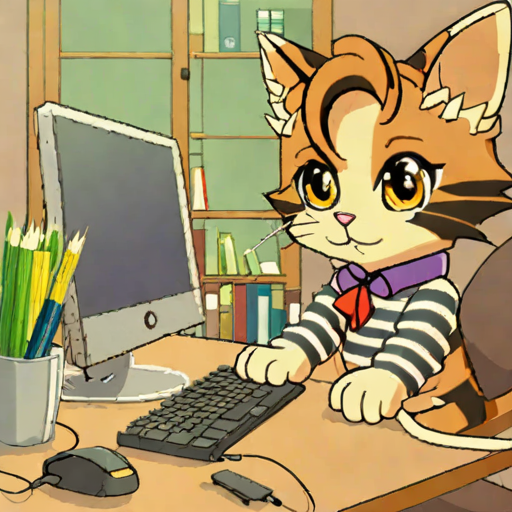

In [ ]:
#@title Generate the image with Stable Diffusion

prompt = response.text
seed = random.randint(0, sys.maxsize)

num_inference_steps = 20

images = pipe(
    prompt = prompt,
    guidance_scale = 0.0,
    num_inference_steps = num_inference_steps,
    generator = torch.Generator("cuda").manual_seed(seed),
    ).images

media.show_images(images)